# Eigenmode filter

This example shows how to use PyAEDT to automate the Eigenmode solver in HFSS.
Eigenmode analysis can be applied to open radiating structures
using an absorbing boundary condition. This type of analysis is useful for
determining the resonant frequency of a geometry or an antenna, and it can be used to refine
the mesh at the resonance, even when the resonant frequency of the antenna is not known.

The challenge posed by this method is to identify and filter the non-physical modes
resulting from reflection from boundaries of the main domain.
Because the Eigenmode solver sorts by frequency and does not filter on the
quality factor, these virtual modes are present when the Eigenmode approach is
applied to nominally open structures.

When looking for resonant modes over a wide frequency range for nominally
enclosed structures, several iterations may be required because the minimum frequency
is determined manually. Simulations re-run until the complete frequency range is covered
and all important physical modes are calculated.

The following script finds the physical modes of a model in a wide frequency
range by automating the solution setup.
During each simulation, a user-defined number of modes is simulated, and the modes
with a Q higher than a user-defined value are filtered.
The next simulation automatically continues to find modes having a frequency higher
than the last mode of the previous analysis.
This continues until the maximum frequency in the desired range is achieved.

Keywords: **HFSS**, **Eigenmode**, **resonance**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Download 3D component
Download the 3D component that is needed to run the example.

In [5]:
project_path = ansys.aedt.core.downloads.download_file(
    "eigenmode", "emi_PCB_house.aedt", temp_folder.name
)

## Launch AEDT

In [6]:
d = ansys.aedt.core.launch_desktop(
    AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_e3e66e51-ac8f-4c17-8c50-53496bddf432.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 58641


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 864.


## Launch HFSS

Create an HFSS design.

In [7]:
hfss = ansys.aedt.core.Hfss(
    version=AEDT_VERSION, project=project_path, non_graphical=NG_MODE
)

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmprze3x_tp.ansys\eigenmode\emi_PCB_house.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 864!


PyAEDT INFO: Project emi_PCB_house has been opened.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmprze3x_tp.ansys\eigenmode\emi_PCB_house.aedt correctly loaded. Elapsed time: 0m 23sec


PyAEDT INFO: Active Design set to with_chassis_em


PyAEDT INFO: Aedt Objects correctly read


## Input parameters for Eigenmode solver

The geometry and material should be already set. The analyses are generated by the code.
The ``num_modes`` parameter is the number of modes during each analysis. The maximum
allowed number is 20. Entering a number higher than 10 might result in a long simulation
time as the Eigenmode solver must converge on modes. The ``fmin`` parameter is the lowest
frequency of interest. The ``fmax`` parameter is the highest frequency of interest.
The ``limit`` parameter determines which modes are ignored.

In [8]:
num_modes = 6
fmin = 1
fmax = 2
next_fmin = fmin
setup_nr = 1
limit = 10
resonance = {}

## Find modes

The following cell defines a function that can be used to create and solve an Eigenmode setup.
After solving the model, information about each mode is saved for subsequent processing.

In [9]:
def find_resonance():
    # Setup creation
    next_min_freq = f"{next_fmin} GHz"
    setup_name = f"em_setup{setup_nr}"
    setup = hfss.create_setup(setup_name)
    setup.props["MinimumFrequency"] = next_min_freq
    setup.props["NumModes"] = num_modes
    setup.props["ConvergeOnRealFreq"] = True
    setup.props["MaximumPasses"] = 10
    setup.props["MinimumPasses"] = 3
    setup.props["MaxDeltaFreq"] = 5

    # Analyze the Eigenmode setup
    hfss.analyze_setup(setup_name, cores=NUM_CORES, use_auto_settings=True)

    # Get the Q and real frequency of each mode
    eigen_q_quantities = hfss.post.available_report_quantities(
        quantities_category="Eigen Q"
    )
    eigen_mode_quantities = hfss.post.available_report_quantities()
    data = {}
    for i, expression in enumerate(eigen_mode_quantities):
        eigen_q_value = hfss.post.get_solution_data(
            expressions=eigen_q_quantities[i],
            setup_sweep_name=f"{setup_name} : LastAdaptive",
            report_category="Eigenmode",
        )
        eigen_mode_value = hfss.post.get_solution_data(
            expressions=expression,
            setup_sweep_name=f"{setup_name} : LastAdaptive",
            report_category="Eigenmode",
        )
        data[i] = [eigen_q_value.data_real()[0], eigen_mode_value.data_real()[0]]

    print(data)
    return data

## Automate Eigenmode solution

Running the next cell calls the resonance function and saves
only those modes with a Q higher than the defined
limit. The ``find_resonance()`` function is called until the complete
frequency range is covered.
When the automation ends, the physical modes in the whole frequency
range are reported.

In [10]:
while next_fmin < fmax:
    output = find_resonance()
    next_fmin = output[len(output) - 1][1] / 1e9
    setup_nr += 1
    cont_res = len(resonance)
    for q in output:
        if output[q][0] > limit:
            resonance[cont_res] = output[q]
            cont_res += 1

resonance_frequencies = [f"{resonance[i][1] / 1e9:.5} GHz" for i in resonance]
print(str(resonance_frequencies))

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving design setup em_setup1


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Design setup em_setup1 solved correctly in 0.0h 0.0m 39.0s


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


{0: [111.36581517444486, 1366596977.42807], 1: [1.2745925586601337, 1487148321.91718], 2: [0.7328320920094917, 1656995430.4749], 3: [0.6768569643872321, 1764794382.269], 4: [0.6667191256549964, 1770605065.50339], 5: [387.49585850937797, 1857246731.91083]}


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving design setup em_setup2


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Design setup em_setup2 solved correctly in 0.0h 0.0m 59.0s


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


{0: [0.7706274548926239, 2112924408.93827], 1: [421.73614867851217, 2279249993.82973], 2: [1.0925438452278264, 2347890555.46697], 3: [1.5912046790850607, 2366196574.26632], 4: [1.8390217225145156, 2518429992.61452], 5: [712.5452288843909, 2761352735.23965]}
['1.3666 GHz', '1.8572 GHz', '2.2792 GHz', '2.7614 GHz']


Plot the model.

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


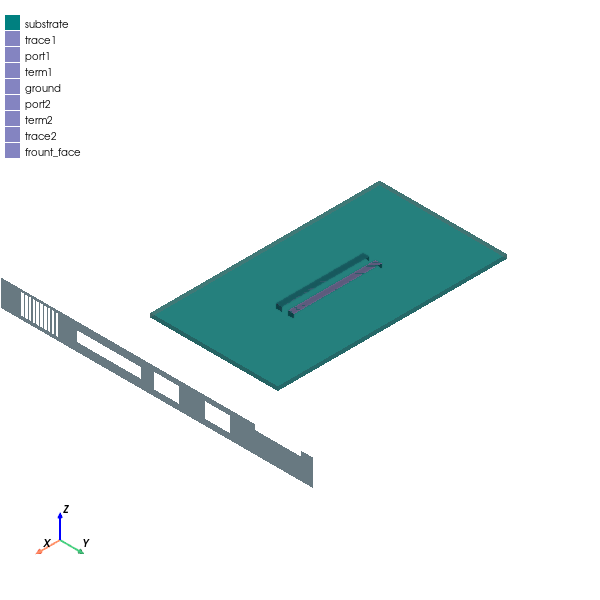

In [11]:
hfss.modeler.fit_all()
hfss.plot(
    show=False,
    output_file=os.path.join(hfss.working_directory, "Image.jpg"),
    plot_air_objects=False,
)

## Release AEDT

In [12]:
hfss.save_project()
d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project emi_PCB_house Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes
all temporary files, including the project folder.

In [13]:
temp_folder.cleanup()